Файл с данными по трансакциям весит 50+ мб, поэтому его помещать в архив я не буду, положу дополнительно html файл. Ноутбук отработает, если положить в директорию с ним исходные файлы с данными без изменений

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline
style.use('bmh')

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

# Импорт и обработка данных

Импортируем данные

In [2]:
goods = pd.read_parquet('nomenclature.parquet')
df = pd.read_parquet('transactions.parquet')
sub_df = pd.read_parquet('transactions-for_submission.parquet')

example = pd.read_parquet('submission-example.parquet')

Сразу посмотрим на пропуски

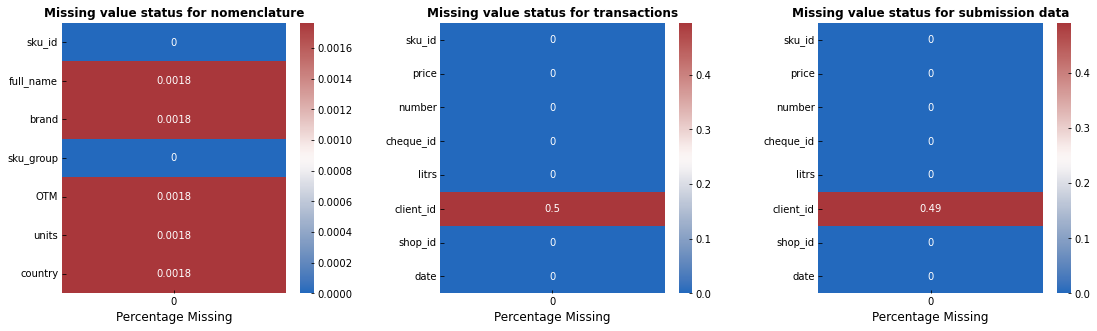

In [3]:
fig, axs = plt.subplots(1, 3, figsize = (16, 5))
sns.heatmap(goods.isna().mean().to_frame(),annot=True,cmap='vlag', ax = axs[0]).set_title('Missing value status for nomenclature',fontweight='bold', fontsize = 12);
sns.heatmap(df.isna().mean().to_frame(),annot=True,cmap='vlag', ax = axs[1]).set_title('Missing value status for transactions',fontweight='bold', fontsize = 12);
sns.heatmap(sub_df.isna().mean().to_frame(),annot=True,cmap='vlag', ax = axs[2]).set_title('Missing value status for submission data',fontweight='bold', fontsize = 12);
fig.tight_layout(pad=3.0)

[ax.set_xlabel('Percentage Missing') for ax in axs];

Так как для более чем половины наблюдений неизвестен id пользователя, очевидно, что чистый user-based подход (например, коллаборативная фильтрация по пользователям) не подойдет.

В номенклатуре есть товары, для которых отсутствует наименование. Если мы посмотрим на эти пропуски, станет очевидно, что все эти товары являются топливом. Заполним пропуски по единицам измерения литрами, по признаку бренда значениями 'да' и 'unknown', все остальное значениями 'unknown'.

In [4]:
goods[goods.isna().any(axis=1)]

,sku_id,full_name,brand,sku_group,OTM,units,country
3724,1158,None,None,Ethereum 92,None,None,None
3727,1157,None,None,Ethereum 95 бренд,None,None,None
3728,1163,None,None,Топливо варповое с присадками летнее,None,None,None
3771,1160,None,None,Топливо варповое зимнее,None,None,None
3787,1159,None,None,Ethereum 95,None,None,None
3825,1162,None,None,Топливо варповое с присадками зимнее,None,None,None
3858,2032,None,None,Ethereum 100 бренд,None,None,None
4407,1161,None,None,Топливо варповое летнее,None,None,None
4922,1771,None,None,Топливо варповое с присадками межсезонное,None,None,None


In [5]:
goods['units'] = goods['units'].fillna('л');
goods.fillna('unknown', inplace = True)
goods.at[3727, 'OTM'] = 'Да'
goods.at[3858, 'OTM'] = 'Да'

Для удобства объеденим информацию из номенклатуры товаров с датасетами с транзакциями по ключу - id товаров

In [6]:
df = pd.merge(df, goods, on='sku_id', how='inner')
sub_df = pd.merge(sub_df, goods, on='sku_id', how='inner')

In [7]:
df[(df['litrs'] > 0) & (df['number'] > 0)].sample(5) # есть какие-то аномалии. Не может быть, чтобы товары такого типа измерялись в литрах

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,full_name,brand,sku_group,OTM,units,country
1793958,1697,0.011750,0.000452,2018803,0.104183,NaN,49,2171-07-04,Напиток Chupa Chups Уранированный апельсин ж/б...,Chupa Chups,"Сладкие Уранированные напитки, холодный чай",Нет,л,КИТАЙ
6169755,184,0.002822,0.000452,559059,0.104183,357065.0,21,2171-04-05,Средство Bestol дизенфицирующее антисептик 60мл,unknown,"Хозяйственные товары, персональный уход",Нет,мл,РОССИЯ
2710156,4502,0.005900,0.000452,1077861,0.104183,334882.0,2,2171-05-27,Сигариллы Captain Black Cherise little cigar,Captain Black,Табачные изделия,Нет,шт,unknown
2919780,4771,0.005900,0.000452,1690762,0.104183,NaN,23,2171-07-23,Набор IQOS 2.4+ черный,IQOS,Табачные изделия,Нет,шт,МАЛАЙЗИЯ
4543986,269,0.011237,0.000452,2146983,0.104183,NaN,1,2171-06-26,Сигареты SOBRANIE super slims pinks,SOBRANIE,Табачные изделия,Нет,шт,РОССИЯ


In [8]:
goods[goods['units'] == 'unknown'].shape

(1718, 7)

В номенклатуре много товаров, для которых неизвестны единицы измерения. Вручную разбираться слишком трудоемко. К тому же, становится очевидно, что единицы измерения никакой полезной информации не несут. Несмотря на то, что некоторые позиции измеряются в литрах, по смыслу очевидно, что отпускаются они поштучно (напитки в банках, вода и т.п.). Воспользуемся информацией от организаторов, которые сообщили, что счетчик показывает неправильные значения и по рекомендации отнимем это значение от 'litrs' (предполагаем, что лишняя прибавка была и у топлива, которое на самом деле измеряется в литрах).

In [9]:
s = float(df['litrs'].mode())
df_temp = df.copy()
df_temp['litrs'] -= s

In [10]:
df_temp[df_temp['litrs'] < 0].shape

(573, 14)

In [11]:
df_temp[df_temp['litrs'] < 0].sample(5)

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,full_name,brand,sku_group,OTM,units,country
987870,1157,0.002568,0.0,2437270,-0.004302,NaN,92,2171-03-18,unknown,unknown,Ethereum 95 бренд,Да,л,unknown
407023,1158,0.002322,0.0,2403316,-0.021350,NaN,9,2171-03-25,unknown,unknown,Ethereum 92,unknown,л,unknown
911936,1157,0.002578,0.0,2437358,-0.003107,NaN,92,2171-04-22,unknown,unknown,Ethereum 95 бренд,Да,л,unknown
716980,1157,0.002635,0.0,2435242,-0.000527,NaN,55,2171-07-21,unknown,unknown,Ethereum 95 бренд,Да,л,unknown
1078826,1163,0.002465,0.0,2402545,-0.000177,NaN,31,2171-06-22,unknown,unknown,Топливо варповое с присадками летнее,unknown,л,unknown


Но, кажется, этот подход не совсем верный. Занулились или стали отрицательными строки с топливом. Попробуем применить другой подход: посмотрим у каких категорий столбец number ненулевой. Если предположение верно, и категории не пересекаются то, можно занулить литры у таких товаров.

In [12]:
 set(df.sku_group.unique()) - set(df[df.number > 0].sku_group.unique()) # из всех групп товаров вычитаем группы с данными по количеству - получаем только топливо

{'Ethereum 100 бренд',
 'Ethereum 92',
 'Ethereum 95',
 'Ethereum 95 бренд',
 'Топливо варповое зимнее',
 'Топливо варповое летнее',
 'Топливо варповое с присадками зимнее',
 'Топливо варповое с присадками летнее',
 'Топливо варповое с присадками межсезонное'}

Похоже, что у всех товаров кроме топлива не должны быть положительные значения по litrs. Обнулим у них этот показатель. (То же самое сделаем со второй таблицей). Также на всякий случай уберем строки, где и number, и litrs оказались нулевыми

In [13]:
df.loc[df.number > 0, 'litrs'] = 0
sub_df.loc[sub_df.number > 0, 'litrs'] = 0

In [14]:
df.drop(df[(df.litrs == 0) & (df.number == 0)].index, inplace = True)
sub_df.drop(sub_df[(sub_df.litrs == 0) & (sub_df.number == 0)].index, inplace = True)

Проверим, ничего ли мы не упустили

In [15]:
print(len(df) == len(df[df.litrs == 0]) + len(df[df.number == 0]))
print(len(sub_df) == len(sub_df[sub_df.litrs == 0]) + len(sub_df[sub_df.number == 0]))

True
True


# Анализ имеющихся признаков и создание новых

Еще раз посмотрим на пропуски, но не типа Nan, а на значения unknown, которые по сути тоже являются пропусками


In [16]:
for col in df.columns:
    unknowns = len(df[df[col] == 'unknown'])
    full_len = len(df)
    print(f'{col}: {str(unknowns)} or {round((unknowns/full_len) * 100, 2)}%')

sku_id: 0 or 0.0%
price: 0 or 0.0%
number: 0 or 0.0%
cheque_id: 0 or 0.0%
litrs: 0 or 0.0%
client_id: 0 or 0.0%
shop_id: 0 or 0.0%
date: 0 or 0.0%
full_name: 2247676 or 29.5%
brand: 2739728 or 35.95%
sku_group: 0 or 0.0%
OTM: 1809118 or 23.74%
units: 848986 or 11.14%
country: 3755514 or 49.28%


In [17]:
for col in goods.columns:
    unknowns = len(goods[goods[col] == 'unknown'])
    full_len = len(goods)
    print(f'{col}: {str(unknowns)} or {round((unknowns/full_len) * 100, 2)}%')

sku_id: 0 or 0.0%
full_name: 1379 or 27.02%
brand: 1733 or 33.96%
sku_group: 0 or 0.0%
OTM: 1377 or 26.98%
units: 1718 or 33.67%
country: 2195 or 43.01%


In [18]:
for col in sub_df.columns:
    unknowns = len(sub_df[sub_df[col] == 'unknown'])
    full_len = len(sub_df)
    print(f'{col}: {str(unknowns)} or {round((unknowns/full_len) * 100, 2)}%')

sku_id: 0 or 0.0%
price: 0 or 0.0%
number: 0 or 0.0%
cheque_id: 0 or 0.0%
litrs: 0 or 0.0%
client_id: 0 or 0.0%
shop_id: 0 or 0.0%
date: 0 or 0.0%
full_name: 214996 or 38.76%
brand: 249034 or 44.89%
sku_group: 0 or 0.0%
OTM: 163479 or 29.47%
units: 51761 or 9.33%
country: 308092 or 55.54%


Видно, что кроме отсутствия информации о клиентах также отсутствует информация о многих товарах. Причем эта информация могла бы быть содержательной (например, покупатели могут отдавать предпочтение определенной стране производства или бренду, а по таким признакам отсутствует до 50% информации)
Из датасетов следует убрать столбец с названием товара. При таком количестве пропусков применять какую-то языковую модель нецелесообразно, тем более, что такая система рекомендаций скорее используется для других целей, а кодировка признаков фиктивными переменными приведет к разрастанию датасета. Конечно, кодировку можно произвести и целевероятностно, но в таком случае самой большой категорией будет категория unknown, что сильно сместит закодированные значения.  
По тем же соображениям уберем столбец brand.  
Признак units кажется бессодержательным, хотя способен кластеризовать группы товаров в еще большие группы по признаку единиц, в которых они измеряются. Однако выше было отмечено, что с единицами измерения возникает некоторая путаница.


Признак country можно было бы и оставить, но в нем слишком много пропусков и довольно много категорий, вычисления будут проблематичными.
А вот признак OTM по смыслу бинарный (если не учитывать неизвестные значения). Его можно оставить и закодировать. Но все-таки уберем его из-за пропусков и относительно большого размера датасета.

In [19]:
df.drop(['full_name', 'brand', 'units', 'country', 'OTM'], axis = 1, inplace = True)
sub_df.drop(['full_name', 'brand', 'units', 'country', 'OTM'],  axis = 1, inplace = True)

Посмотрим на признак даты и попробуем разложить его на компоненты

In [20]:
(df['date'].max(), df['date'].min(), df['date'].max() - df['date'].min())

(Timestamp('2171-07-31 00:00:00'),
 Timestamp('2171-03-01 00:00:00'),
 Timedelta('152 days 00:00:00'))

In [21]:
(sub_df['date'].max(), sub_df['date'].min(), sub_df['date'].max() -  sub_df['date'].min())

(Timestamp('2171-09-01 09:00:00'),
 Timestamp('2171-08-01 09:00:00'),
 Timedelta('31 days 00:00:00'))

Видно, что трейн по времени занимает 5 месяцев, а тест - 1. При этом временные отрезки не пересекаются, а трейн не содержит информации о транзакциях за полный календарный год. Это значит, что определить сезонность в рамках года не получится, однако можно попробовать уловить закономерности в рамках месяца, недели и дня.  
Разложим признак date на компоненты.

In [22]:
# получаем номер дня недели наблюдения
df['day_week_num'] = df['date'].apply(lambda x: x.dayofweek)
# получаем информацию о дне наблюдения - выходной или рабочий день
df['day_week_status'] = df['day_week_num'].apply(
    lambda x: 1 if 1 <= x <= 5 else 0
)
# получаем номер часа наблюдения
df['hour_num'] = df['date'].apply(lambda x: x.hour)
# отбрасываем колонку с пандасовской датой
df.drop(columns=['date'], inplace=True)

Посчитаем вероятность попадания группы товаров в чек (независимо от количества товаров группы в чеке).

In [23]:
df_feature_gen= df[['cheque_id', 'sku_id', 'sku_group']]

In [24]:
# группируем по чеку и группе товара. То есть получаем уникальные группы товаров в каждом чеке
group_freq_df = df_feature_gen.groupby(['cheque_id','sku_group']).count().reset_index()
# общее количество чеков в датасете
cheque_num =df_feature_gen['cheque_id'].unique().shape[0]
# считаем популярность групп (вероятность попадания группы товаров в чек)
group_freq = (group_freq_df['sku_group'].value_counts() / cheque_num).to_dict()

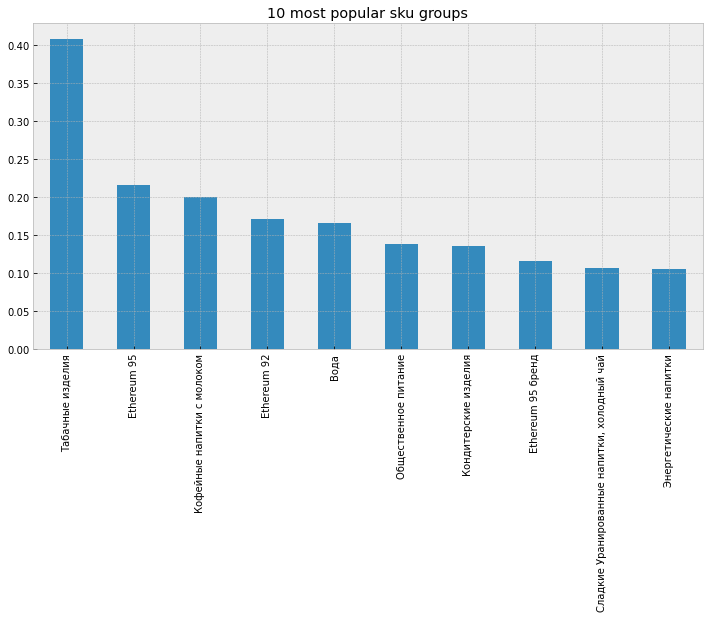

In [25]:
pd.Series(group_freq)[:10].plot.bar(figsize = (12, 6), title = '10 most popular sku groups');

In [26]:
df_feature_gen1 = df_feature_gen[['sku_id', 'sku_group']]
# добавляем столбец единиц, чтобы количество товаров в группе для каждого чека не учитывалось
df_feature_gen1['ones'] = np.ones(df.shape[0])
# считаем количество вхождений каждого товара в чек по группам
df_group_sku = df_feature_gen1.groupby(['sku_group','sku_id']).count().reset_index()
# создадим словарь, где ключ - группа товаров, значение - суммарное количество уникальных sku_id, вошедших в группы
group_sku_sum = df_feature_gen1['sku_group'].value_counts().to_dict()
# теперь можем посчитать вероятность вхождения товара в группу (можно интерпретировать как вероятность того, что товар
# войдет в чек, если покупатель делает покупку товара из определенной группы)
df_sku_group_freq = df_group_sku.copy()
for i in range(len(df_sku_group_freq)):
    df_sku_group_freq['ones'].iloc[i] /= group_sku_sum[df_sku_group_freq['sku_group'].iloc[i]]

In [27]:
# создадим таблицу с вероятностями покупки группы и конкретного товара из группы
df_sku_group_freq.columns = ['sku_group', 'sku_id', 'sku_proba']
df_sku_group_freq['group_proba'] = np.zeros(len(df_sku_group_freq))
for i in range(len(df_sku_group_freq)):
    df_sku_group_freq['group_proba'].iloc[i] = group_freq[df_sku_group_freq['sku_group'].iloc[i]]
    
df_sku_group_freq.head(5)

,sku_group,sku_id,sku_proba,group_proba
0,Ethereum 100 бренд,2032,1.000000,0.037320
1,Ethereum 92,1158,1.000000,0.171110
2,Ethereum 95,1159,1.000000,0.216235
3,Ethereum 95 бренд,1157,1.000000,0.115923
4,Автотовары,1,0.005276,0.009184


# Создание рекомендательной системы

Итак, мы нашли вероятности. Самый очевидный подход - найти самую популярную группу товаров и предложить из нее 20 самых популярных товаров из еще не купленных. Но по такой логике всем следует предлагать кофейные напитки, потому что это самая популярная группа. Неплохо бы учесть связь между категориями. Попробуем поискать ближайших соседей по группам. Считать соседей по всему датасету довольно ресурсозатратно, к тому же не особо понятно как это делать. Поэтому найдем соседей по агрегированным данным (здесь нет уверенности, что добавлять вероятность в признаки хорошая идея)

In [28]:
df_group_knn = df.copy()

In [29]:
df_group_knn = df_group_knn[['sku_group', 'price', 'number', 'litrs', 'day_week_num', 'day_week_status']] # hour_num везде нули, поэтому не берем признак
df_group_knn['group_proba'] = df_group_knn['sku_group']
# добавим столбец с популярностью групп. Для этого скопируем столбец с названиями групп, а затем подадим в 
# replace ранее созданный словарь с вероятностями
df_group_knn['group_proba'].replace(group_freq, inplace=True)
df_group_knn = df_group_knn.groupby('sku_group').mean()
df_group_knn.head(5)

,price,number,litrs,day_week_num,day_week_status,group_proba
sku_group,,,,,,
Ethereum 100 бренд,0.002920,0.000000,0.146767,2.904583,0.719789,0.037320
Ethereum 92,0.002325,0.000000,0.131389,2.941213,0.706655,0.171110
Ethereum 95,0.002564,0.000000,0.137917,2.914430,0.709141,0.216235
Ethereum 95 бренд,0.002642,0.000000,0.140850,2.910566,0.711600,0.115923
Автотовары,0.026393,0.000476,0.000000,2.904368,0.709409,0.009184


In [30]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

scaler = MinMaxScaler() # отнормируем данные
group_scaled = scaler.fit_transform(df_group_knn)

knn = NearestNeighbors() # настраивать какие-то гиперпараметры нет особого смысла
knn.fit(group_scaled)
distances, indices = knn.kneighbors(group_scaled, n_neighbors=39)


Вообще говоря, аналогичные действия можно было бы проделать и с товарами (сгруппировать, найти ближайших соседей). Но, кажется, что такой подход будет менее эффективным и во многом случайным. Первый подходящий сосед может находиться очень далеко от купленного товара и в целом слабо соответствовать реальному предпочтению покупателя.

Теперь реализуем следующий алгоритм рекомендации товаров:
1. Определяем группу, из которой покупатель совершил покупку товара.  
2. Если эта группа та же, из которой нам нужно порекомендовать товары, рекомендуем 20 самых популярных товаров группы. (Во всех группах сильно больше 20 товаров, поэтому будем считать, что они не закончатся).  
3. Если есть несколько подходящих групп, откуда уже совершена покупка, рекомендуем 20 самых популярных товаров из самой популярной группы.  
4. Если в чеке нет групп, из которых нам требуется рекомендовать товар, то берем ближайшего подходящего соседа-группу. Если куплено несколько товаров из разных групп, то берем соседа той группы, у для которой подходящий сосед ближе. Если у 2х групп ближайший сосед стоит на одной позиции, то выбираем группу-соседа произвлольно. Рекомендуем 20 самых популярных товаров из найденной группы.

In [31]:
target_groups = ['Вода', 'Сладкие Уранированные напитки, холодный чай', 'Кофейные напитки с молоком',
                 'Энергетические напитки', 'Снеки', 'Соки и сокосодержащие напитки']
# отберем из результатов КНН только индексы, которые нам подходят, причем учтем позицию (близость соседа)
df_group_knn = df_group_knn.reset_index()
target_index = df_group_knn[df_group_knn['sku_group'].isin(target_groups)].index.tolist()

fitted_neighbours = indices[:, 1:].tolist()

# ищем индексы из целевых групп и к ним в список кладем позицию
for j in range(len(fitted_neighbours)):
    pos = 0
    for i in range(len(fitted_neighbours[0])):
        if fitted_neighbours[j][i] in target_index:
            fitted_neighbours[j][i] = [fitted_neighbours[j][i], pos]
        pos += 1

# делаем список списков, где первый элемент - название группы товаров, второй - позиция
neighbours_id_dict = df_group_knn['sku_group'].to_dict()
fitted_neighbours = np.array([[neighbours_id_dict[i[0]], i[1]] for j in fitted_neighbours for i in j if type(i) == list]).reshape(-1, len(target_groups), 2).tolist()

# а теперь делаем словарь, сопостовляя группу, для которой мы искали соседа и её соседей
neighbours_dict = {k:v for k, v in zip(df_group_knn['sku_group'], fitted_neighbours)}

{'Ethereum 100 бренд': [['Соки и сокосодержащие напитки', '10'],
  ['Снеки', '12'],
  ['Сладкие Уранированные напитки, холодный чай', '17'],
  ['Энергетические напитки', '19'],
  ['Вода', '25'],
  ['Кофейные напитки с молоком', '29']],
 'Ethereum 92': [['Кофейные напитки с молоком', '8'],
  ['Вода', '10'],
  ['Сладкие Уранированные напитки, холодный чай', '13'],
  ['Энергетические напитки', '14'],
  ['Снеки', '16'],
  ['Соки и сокосодержащие напитки', '18']],
 'Ethereum 95': [['Кофейные напитки с молоком', '8'],
  ['Вода', '9'],
  ['Сладкие Уранированные напитки, холодный чай', '12'],
  ['Энергетические напитки', '14'],
  ['Снеки', '16'],
  ['Соки и сокосодержащие напитки', '19']],
 'Ethereum 95 бренд': [['Сладкие Уранированные напитки, холодный чай', '10'],
  ['Энергетические напитки', '11'],
  ['Вода', '13'],
  ['Кофейные напитки с молоком', '15'],
  ['Снеки', '16'],
  ['Соки и сокосодержащие напитки', '18']],
 'Автотовары': [['Соки и сокосодержащие напитки', '5'],
  ['Снеки', '6'],


In [32]:
# создадим словарь, где ключ - название группы, а значение - список sku_id, отсортированных по популярности
df_target_groups_proba = df_sku_group_freq[df_sku_group_freq['sku_group'].isin(target_groups)]

sku_popularity_dict = dict.fromkeys(target_groups)
for group in target_groups:
    sku_popularity_dict[group] = df_target_groups_proba[df_target_groups_proba['sku_group'] == group].iloc[:, -3:-1].sort_values(
        by = 'sku_proba', ascending = False)['sku_id'].values.tolist()


Можем перейти к составлению рекомендаций. Это все можно переписать в виде классов и функций, но что-то не хочется, потому что это довольно долго, а качество такой рексистемы сомнительно, использовать ее серьезно точно не стоит.

In [34]:
sub_df = sub_df[['cheque_id', 'sku_group', 'sku_id']]
target_groups_freq = {k:v for k, v in group_freq.items() if k in target_groups}
sub_cheques = sub_df.cheque_id.unique()

row_list = []
# итерируемся по чекам, для каждого чека находим уникальные группы товаров и уникальные товары, кладем всё в списки
for cheque in sub_cheques:
    purch = sub_df[sub_df['cheque_id'] == cheque]
    purch_all_groups = purch.sku_group.unique()
    purch_all_sku_id = purch.sku_id.unique()
# смотрим, покупает ли клиент что-то из целевых групп
    common_groups = (set(purch_all_groups) & set(target_groups))
# если покупает, то выбираем из этих групп самую популярную (из словаря популярности целевых групп выбираем
# общие ключи-группы и выбираем группу с наибольшей популярностью)
    if len(common_groups) != 0:
        common_groups_freq = {k:target_groups_freq[k] for k in common_groups if k in target_groups_freq}
        target_group = max(common_groups_freq, key=common_groups_freq.get)
# если нет - то берем у всех групп ближайшего соседа и выбираем того, который ближе к какой-нибудь из купленных групп
    else:
        neighbours = {}
        for group in purch_all_groups:
            neighbours[neighbours_dict[group][0][0]] = int(neighbours_dict[group][0][1])
        target_group = min(neighbours, key=neighbours.get)
# теперь берем 20 самых популярных товаров из еще не купленных из найденной целевой группы
    rec_sku_id = []
    for sku_id in sku_popularity_dict[target_group]:
        if (sku_id not in purch_all_sku_id) and (len(rec_sku_id) <= 20):
            rec_sku_id.append(sku_id)
# записываем все в список, чтобы потом создать датафрейм
    row_list.append([[cheque, sku, pos] for sku, pos in zip(rec_sku_id, range(1, 21))])
    
row_list = [l for subl in row_list for l in subl]    
submission_result = pd.DataFrame(row_list, columns = ['cheque_id', 'sku_id', 'position'])   
                

In [35]:
submission_result.head(5)

,cheque_id,sku_id,position
0,734259,3329,1
1,734259,3324,2
2,734259,3334,3
3,734259,3330,4
4,734259,1551,5


In [ ]:
# экспортируем предсказания
submission_result.to_parquet('submission-{Удинский_Евгений}.parquet')

Поскольку предложен 1 вариант рексистемы, метрики проверять мы не будем. Чтобы нормально посчитать метрики требуется разделение на тест и трейн, соответственно часть данных из трейна потеряется, а submission необходимо делать по другим данным. К тому же есть вопросы как это делать, ведь рекомендовать нам надо из определенных групп, а значит нам подойдут только чеки, где есть товары из нужных групп. То есть выборка будет неслучайной. Тем более, что содержательные ML модели по всем данным мы не обучали (кроме KNN), смысла считать метрики нет.